In [1]:
import gdown
import pandas as pd
import random
import json

In [ ]:
# gdown.download('https://drive.google.com/file/d/17NBXx6l_6znStM52RJOKKKlxnHigavzq/view', fuzzy=True)

In [ ]:
# tar -xvzf hackathon_objects.tar.gz

In [2]:
goods_data = pd.read_parquet('../datasets/train_data.parquet')

goods_pairs = pd.read_parquet('../datasets/train_pairs_w_target.parquet')

In [3]:
def symm_pairs(df):
    # todo: complete cliques of goods
    
    df2 = df.copy()
    cols = ["variantid1", "variantid2"]
    for c in cols:
        if c not in df2.columns:
            raise UserWarning
    df2 = df2.rename(columns={cols[0]: cols[1], cols[1]: cols[0]})
    return pd.concat([df, df2]).drop_duplicates()

In [4]:
import torch
import random
import numpy as np
from torch.utils.data import Dataset, DataLoader


class ContrastiveDataset(Dataset):
    def __init__(self, original_dataset, pairs_dataset, embedding_columns, mode = True):
        self.original_dataset = original_dataset.set_index('variantid')
        self.pairs_dataset = pairs_dataset
        self.embedding_columns = embedding_columns
        self.dataset = None
        self.mode = mode
        if self.mode:
            self.prepare_dataset()

        else:
            self.prepare_test_dataset()
        self.prepare_data()
        

    def prepare_dataset(self):
        neg_pairs =  self.pairs_dataset[ self.pairs_dataset.target ==0.].groupby('variantid1').variantid2.apply(lambda x: list(x)).to_frame()
        pos_pairs =  self.pairs_dataset[ self.pairs_dataset.target ==1.].groupby('variantid1').variantid2.apply(lambda x: list(x)).to_frame()
        self.dataset = pos_pairs.merge(neg_pairs, how = 'outer', left_index = True, right_index = True, suffixes = ['_pos', '_neg'])
        sol = pd.Series(np.where(self.dataset.variantid2_pos.notnull(), self.dataset.variantid2_pos, pd.Series(self.dataset.index).apply(lambda x: [x])))
        self.dataset['variantid2_pos'] = sol.set_axis(self.dataset.index)
        ld = pd.Series(self.dataset.index).sample(frac = 1).apply(lambda x: [x])
        sol = pd.Series(np.where(self.dataset.variantid2_neg.notnull(), self.dataset.variantid2_neg, ld))
        self.dataset['variantid2_neg'] = sol.set_axis(self.dataset.index)
        self.dataset = self.dataset.reset_index()

        
    def prepare_data(self):
        self.original_dataset = self.original_dataset.apply(lambda x: torch.cat([torch.tensor(x['main_pic_embeddings_resnet_v1'][0]), torch.tensor(x['name_bert_64'])], axis =0), axis =1)
    
    def prepare_test_dataset(self):
        self.dataset = self.pairs_dataset[['variantid1']].reset_index(drop=True)



    def __getitem__(self, index):
        original_idx = self.dataset.loc[index].variantid1
        if self.mode:
            positive_idx = self.dataset.loc[index].variantid2_pos
            negative_idx = self.dataset.loc[index].variantid2_neg
            if len(positive_idx)>1:
                val = np.random.choice(len(positive_idx), 1)[0]
                positive_idx = positive_idx[val]
            else:
                positive_idx = positive_idx[0]
            if len(negative_idx)>1:
                val = np.random.choice(len(negative_idx), 1)[0]
                negative_idx = negative_idx[val]
            else:
                negative_idx = negative_idx[0]
            positive_pair = self.original_dataset.loc[positive_idx]
            negative_pair = self.original_dataset.loc[negative_idx]
            original_data = self.original_dataset.loc[original_idx]
          #  print(original_data)
            return original_data, positive_pair, negative_pair, original_idx
        else:
            original_data = self.original_dataset.loc[original_idx]
            return original_data, original_idx


    def __len__(self):
        return len(self.dataset)



# Actual data

In [5]:
symm_goods_pairs = symm_pairs(goods_pairs)

In [ ]:
pos_pairs = symm_goods_pairs[symm_goods_pairs.target ==1].groupby('variantid1').variantid2.apply(lambda x: list(x)).to_frame()
#checking if lists contain duplicates
pos_pairs.variantid2.apply(lambda x: len(x) !=len(set(x))).value_counts()
# добавить все симметричные positive pairs
pos_pairs.variantid2.str.len().value_counts()

1     189650
2      18977
3       3806
4       1403
5        734
6        561
7        380
8        287
9        247
10       190
11       166
12       129
13       115
14        72
15        55
16        40
17        24
18        22
20        15
19        14
21         6
22         5
25         3
26         3
23         2
27         2
24         2
28         1
Name: variantid2, dtype: int64

In [6]:
embedding_columns = ['main_pic_embeddings_resnet_v1', 'name_bert_64']

contrastive_dataset = ContrastiveDataset(goods_data, symm_goods_pairs, embedding_columns, mode= True)
contrastive_dataloader = DataLoader(contrastive_dataset, batch_size=128, shuffle=False, drop_last= False, num_workers = 8)
next(iter(contrastive_dataloader))[0].shape

torch.Size([128, 192])

In [7]:
yt = next(iter(contrastive_dataloader))
yt[0].shape, yt[1].shape, yt[2].shape

(torch.Size([128, 192]), torch.Size([128, 192]), torch.Size([128, 192]))

# Basic train example

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm

In [9]:
#!g1.1

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
#!g1.1
class ContrastiveModel(nn.Module):
    def __init__(self, input_size, hidden_size, embedding_size):
        super(ContrastiveModel, self).__init__()
        
        self.input_size = input_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, embedding_size)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def triplet_loss(anchor, positive, negative, margin=1.0):
    distance_positive = torch.norm(anchor - positive, dim=1)
    distance_negative = torch.norm(anchor - negative, dim=1)
    loss = torch.clamp(distance_positive - distance_negative + margin, min=0.0).mean()
    return loss

# Example parameters
input_size = 192
hidden_size = 64
embedding_size = 32
learning_rate = 0.001
num_epochs = 10

# Create an instance of the model
model = ContrastiveModel(input_size, hidden_size, embedding_size).to(device)

# Define the optimizer and the loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train loop
def train(model, contrastive_dataloader, optimizer):
    for epoch in tqdm(range(num_epochs)):
        total_loss = 0.0
        
        for original_data, positive_pair, negative_pair, _ in tqdm(contrastive_dataloader):
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            anchor = model(original_data.to(device))
            positive = model(positive_pair.to(device))
            negative = model(negative_pair.to(device))
            
            # Compute the triplet loss
            loss = triplet_loss(anchor, positive, negative)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
    #     print(loss.item())
            total_loss += loss.item()
        
        average_loss = total_loss / len(contrastive_dataloader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss:.4f}")


In [ ]:
torch.save(model.state_dict(), 'contrastive_ozon.pt')

In [11]:
model = ContrastiveModel(input_size, hidden_size, embedding_size).to(device)
model.load_state_dict(torch.load('./contrastive_ozon.pt'))

<All keys matched successfully>

In [12]:
def predict(model, dataloader):
    y_idxs = []
    y_embed = []
    for orig, _, _, idx in tqdm(dataloader):
        embed = model(orig.to(device))
        y_idxs.extend([i.detach().cpu().item() for i in idx])
        y_embed.extend([[j.item() for j in i.detach().cpu()] for i in embed])
    return y_idxs, y_embed

y_idxs, y_embed = predict(model, contrastive_dataloader)

        


  0%|          | 0/3569 [00:00<?, ?it/s]

In [13]:
embed = pd.DataFrame({'variant': y_idxs, 'embed': y_embed})
classif = goods_pairs.merge(embed, left_on = 'variantid1', right_on = 'variant', how = 'left', suffixes = ['', '_1'])
classif = classif.merge(embed, left_on = 'variantid2', right_on='variant', how = 'left', suffixes = ['', '_2'])
classif.drop(['variant', 'variant_2'],axis = 1, inplace = True)

In [14]:
from sklearn.metrics.pairwise import cosine_similarity
def get_pic_features(main_pic_embeddings_1,
                     main_pic_embeddings_2):
    """Calculate distances percentiles for 
    pairwise pic distances. Percentiles are useful 
    when product has several pictures.
    """
     
    embed= list(np.abs(np.array(main_pic_embeddings_1)[None, ...] - np.array(main_pic_embeddings_2)[None, ...])[0])

    cos_sim = cosine_similarity(
        np.array(main_pic_embeddings_1)[None, ...], np.array(main_pic_embeddings_2)[None, ...]
    )[0][0]
    

    # pair_features = []
    # pair_features += np.percentile(dist_m, percentiles).tolist()

    return embed, cos_sim

In [15]:

classif[["embed_dif", "cos_sim", ]] = (
    classif[["embed", "embed_2"]].apply(
        lambda x: pd.Series(get_pic_features(*x)), axis=1
    )
)

In [16]:
classif = classif.merge(goods_data[['variantid', 'categories']], left_on = 'variantid1', right_on = 'variantid', how = 'left')
classif["cat3"] = classif["categories"].apply(lambda x: json.loads(x)["3"])
cat3_counts = classif["cat3"].value_counts().to_dict()
classif["cat3_grouped"] = classif["cat3"].apply(lambda x: x if cat3_counts[x] > 1000 else "rest")

In [17]:
dikt_categories= {i: j for i, j in zip(classif.cat3_grouped.unique(), range(classif.cat3_grouped.nunique()))}
classif['category'] = classif.cat3_grouped.map(dikt_categories)
embeddings = pd.DataFrame(classif['embed_dif'].tolist())
data = pd.concat([classif, embeddings], axis = 1)
data= data[['target', 'variantid1', 'variantid2',  'cos_sim', 'cat3_grouped', 'category']+list(embeddings.columns)]

In [111]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#в итоге убираю categories, с ней работает гораздо хуже

X_train, X_test = train_test_split(
    data, 
    test_size=0.1, random_state=42, stratify=classif[["target", "cat3_grouped"]]
)

y_test = X_test[["target", "variantid1", "variantid2", ]]
cat_test = X_test["cat3_grouped" ]
X_test = X_test.drop(["target", "cat3_grouped", 'category'], axis=1)

y_train = X_train["target"]
cat_train = X_train["cat3_grouped"]
X_train = X_train.drop(["target", "cat3_grouped",  'category'], axis=1)
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc =scaler.transform(X_test)
train_pool = Pool(
    data=X_train,
    label=y_train,
)
eval_pool = Pool(
    data=X_test,
    label=y_test['target']
)

/home/andreychuk/.venv/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/home/andreychuk/.venv/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/home/andreychuk/.venv/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [103]:
# from sklearn.linear_model import LogisticRegression
# clf = LogisticRegression(penalty='l2')
# clf.fit(X_train_sc, y_train)

LogisticRegression()

In [112]:
model_cat = CatBoostClassifier(iterations = 100)

model_cat.fit(
   train_pool,
    eval_set = eval_pool,
 #   n_jobs=10, 
 #   plot=True,
    verbose=True,
    use_best_model=True,
    early_stopping_rounds=50,
    metric_period=100
)

Learning rate set to 0.345756
0:	learn: 0.6619167	test: 0.6619180	best: 0.6619180 (0)	total: 25.8ms	remaining: 2.55s


99:	learn: 0.5670907	test: 0.5745963	best: 0.5745830 (98)	total: 1.78s	remaining: 0us

bestTest = 0.5745829875
bestIteration = 98

Shrink model to first 99 iterations.


In [113]:
import numpy as np
from sklearn.metrics import precision_recall_curve, auc


def pr_auc_macro(
    target_df: pd.DataFrame,
    predictions_df: pd.DataFrame,
    prec_level: float = 0.75,
    cat_column: str = "cat3_grouped",
    cat_df: pd.DataFrame = cat_test
) -> float:
    
    df = target_df.merge(predictions_df, on=["variantid1", "variantid2"])
    
    y_true = df["target"]
    y_pred = df["scores"]
    categories = cat_df
    
    weights = []
    pr_aucs = []

    unique_cats, counts = np.unique(categories, return_counts=True)

    for i, category in enumerate(unique_cats):
        cat_idx = np.where(categories == category)[0]
        y_pred_cat = y_pred[cat_idx]
        y_true_cat = y_true[cat_idx]

        y, x, thr = precision_recall_curve(y_true_cat, y_pred_cat)
        gt_prec_level_idx = np.where(y >= prec_level)[0]

        try:
            pr_auc_prec_level = auc(x[gt_prec_level_idx], y[gt_prec_level_idx])
            if not np.isnan(pr_auc_prec_level):
                pr_aucs.append(pr_auc_prec_level)
                weights.append(counts[i] / len(categories))
        except ValueError as err:
            pr_aucs.append(0)
            weights.append(0)
    return np.average(pr_aucs, weights=weights)

In [87]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve, auc


def pr_auc_macro(
    target_df: pd.DataFrame,
    predictions_df: pd.DataFrame,
    prec_level: float = 0.75,
    cat_column: str = "cat3_grouped",
    cat_df: pd.DataFrame = cat_test
) -> float:
    
    df = target_df.merge(predictions_df, on=["variantid1", "variantid2"])
    
    y_true = df["target"]
    y_pred = df["scores"]
    categories = cat_df
    
    weights = []
    pr_aucs = []

    unique_cats, counts = np.unique(categories, return_counts=True)

    for i, category in enumerate(unique_cats):
        cat_idx = np.where(categories == category)[0]
        y_pred_cat = y_pred[cat_idx]
        y_true_cat = y_true[cat_idx]

        y, x, thr = precision_recall_curve(y_true_cat, y_pred_cat)
        gt_prec_level_idx = np.where(y >= 0)[0]

        try:
            pr_auc_prec_level = auc(x[gt_prec_level_idx], y[gt_prec_level_idx])
            if not np.isnan(pr_auc_prec_level):
                pr_aucs.append(pr_auc_prec_level- prec_level)
                weights.append(counts[i] / len(categories))
        except ValueError as err:
            pr_aucs.append(0)
            weights.append(0)
    return np.average(pr_aucs, weights=weights)


In [114]:
X_test['scores'] = model_cat.predict_proba(X_test)[:, 1]

In [115]:
pr_auc_macro_metr = pr_auc_macro(
    target_df=y_test, 
    predictions_df=X_test,
    prec_level=0.75,
    cat_column="cat3_grouped", 
    cat_df= cat_test
)

pr_auc_macro_metr

0.32331692284250807

In [ ]:
#используется только одна картинка, можно делать positive pairs со всеми

<AxesSubplot:>

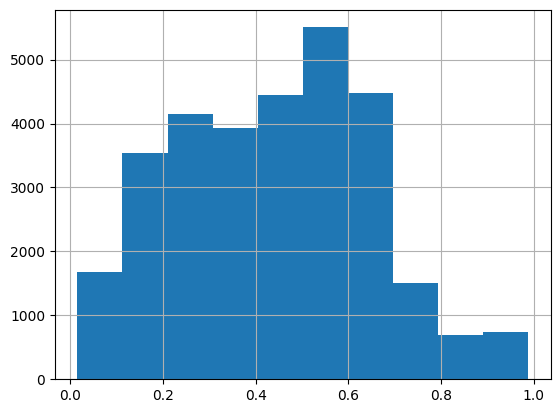

In [116]:
pd.Series(X_test['scores']).hist()

# Submission

In [117]:
#test_pairs = pd.read_parquet("../datasets/test_pairs_wo_target.parquet")
test_pairs = pd.read_csv("../datasets/test_for_participants.csv")
test_etl = pd.read_parquet("../datasets/test_data.parquet")

In [118]:
embedding_columns = ['main_pic_embeddings_resnet_v1', 'name_bert_64']
symm_goods_pairs = symm_pairs(test_pairs)
dataset_test = ContrastiveDataset(test_etl, symm_goods_pairs, embedding_columns, mode = False)
test_dataloader = DataLoader(dataset_test, batch_size=128, shuffle=False, drop_last= False, num_workers =7)

In [119]:
yt = next(iter(test_dataloader))

In [120]:
def predict(model, dataloader):
    y_idxs = []
    y_embed = []
    for orig, idx in tqdm(dataloader):
        embed = model(orig.to(device))
        y_idxs.extend([i.detach().cpu().item() for i in idx])
        y_embed.extend([[j.item() for j in i.detach().cpu()] for i in embed])
    return y_idxs, y_embed

y_idxs, y_embed = predict(model, test_dataloader)

        


  0%|          | 0/283 [00:00<?, ?it/s]

In [121]:
embed = pd.DataFrame({'variant': y_idxs, 'embed': y_embed})
classif = test_pairs.merge(embed, left_on = 'variantid1', right_on = 'variant', how = 'left', suffixes = ['', '_1'])
classif = classif.merge(embed, left_on = 'variantid2', right_on='variant', how = 'left', suffixes = ['', '_2'])
classif.drop(['variant', 'variant_2'],axis = 1, inplace = True)

In [122]:
classif

,variantid1,variantid2,embed,embed_2
0,372065731,372070671,"[1.6525622606277466, -3.2439792156219482, 1.51...","[0.6750813126564026, -2.1645538806915283, 2.00..."
1,528068358,533445916,"[0.005696989595890045, -1.3313469886779785, 3....","[0.8352844715118408, -2.027942419052124, 3.344..."
2,480899084,480899989,"[-1.832124948501587, 0.48868897557258606, 1.28...","[-3.8057878017425537, -0.09418486803770065, 0...."
3,384479474,488458602,"[-4.925470352172852, 5.771787166595459, -0.819...","[-3.441995620727539, 4.656591892242432, -1.367..."
4,658044199,663187587,"[-1.116568684577942, 1.8577327728271484, 0.056...","[-3.4046566486358643, 4.571574687957764, 3.105..."
...,...,...,...,...
19002,405934001,695957034,"[-4.9288530349731445, -0.8200416564941406, 1.2...","[-4.291055202484131, -1.5159084796905518, 1.53..."
19003,692224892,692246989,"[-0.8456848859786987, 0.17000892758369446, 0.6...","[-1.5315381288528442, 1.7129992246627808, 0.06..."
19004,388824213,658486072,"[-5.06603479385376, 3.2865912914276123, 2.9591...","[-3.2435405254364014, 2.201007604598999, 4.590..."
19005,479858327,480111601,"[-1.6977787017822266, -0.2960455119609833, 3.0...","[-2.1160013675689697, 0.30456051230430603, 2.6..."


In [123]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
def get_pic_features(main_pic_embeddings_1,
                     main_pic_embeddings_2):
    """Calculate distances percentiles for 
    pairwise pic distances. Percentiles are useful 
    when product has several pictures.
    """
     
    embed= list(np.abs(np.array(main_pic_embeddings_1)[None, ...] - np.array(main_pic_embeddings_2)[None, ...])[0])

    cos_sim = cosine_similarity(
        np.array(main_pic_embeddings_1)[None, ...], np.array(main_pic_embeddings_2)[None, ...]
    )[0][0]
    

    # pair_features = []
    # pair_features += np.percentile(dist_m, percentiles).tolist()

    return embed, cos_sim

In [124]:

classif[["embed_dif", "cos_sim", ]] = (
    classif[["embed", "embed_2"]].apply(
        lambda x: pd.Series(get_pic_features(*x)), axis=1
    )
)

In [125]:
classif = classif.merge(test_etl[['variantid', 'categories']], left_on = 'variantid1', right_on = 'variantid', how = 'left')
classif["cat3"] = classif["categories"].apply(lambda x: json.loads(x)["3"])
cat3_counts = classif["cat3"].value_counts().to_dict()


In [126]:
classif["cat3_grouped"] = classif["cat3"].apply(lambda x: x if cat3_counts[x] > 1000 else "rest")

In [276]:
dikt_categories= {i: j for i, j in zip(classif.cat3_grouped.unique(), range(classif.cat3_grouped.nunique()))}
classif['category'] = classif.cat3_grouped.map(dikt_categories)
embeddings = pd.DataFrame(classif['embed_dif'].tolist())
data = pd.concat([classif, embeddings], axis = 1)

In [127]:
data= data[['variantid1', 'variantid2',  'cos_sim']+list(embeddings.columns)] #'category'

In [130]:
data

,variantid1,variantid2,cos_sim,0,1,2,3,4,5,6,...,22,23,24,25,26,27,28,29,30,31
0,51197862,51198054,0.413231,0.850892,1.419359,1.449553,1.744147,1.871272,1.830117,2.390528,...,0.214506,1.129993,1.254275,1.736705,0.905519,0.151526,1.015846,0.537169,0.603081,0.605535
1,53062686,536165289,0.994501,0.724834,0.865314,0.180181,0.179855,0.108675,0.878026,0.023633,...,0.183326,0.442302,0.175646,0.610802,0.374828,0.170219,0.158223,0.243014,0.194189,0.219698
2,53602615,587809782,0.954776,0.617691,0.397453,0.696961,2.223639,1.486794,0.372180,1.089606,...,0.434875,0.570757,1.455370,0.439040,0.049713,1.091714,0.114849,0.287817,0.388773,0.741397
3,53888651,89598677,0.987757,1.159205,0.850549,0.602239,1.212186,0.992001,0.287687,0.317939,...,0.796361,0.153266,0.426669,0.790466,0.388277,0.716095,0.326445,0.063538,0.074501,0.475873
4,56930698,551526166,0.996819,0.036095,0.212312,0.085747,0.292147,0.062271,0.145790,0.075920,...,0.422532,0.186402,0.114349,0.038073,0.446134,0.120203,0.434610,0.115591,0.003185,0.290676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306535,817327230,822083612,0.999461,0.108054,0.064370,0.171312,0.057446,0.216250,0.030313,0.272700,...,0.102231,0.039616,0.005920,0.005734,0.143971,0.145606,0.229809,0.188015,0.155154,0.091037
306536,817560551,818069912,0.827965,0.016449,0.007624,0.605001,0.444642,0.506917,0.926046,0.794408,...,0.017004,0.519530,0.278388,0.577257,0.028803,0.517250,0.624337,1.020518,0.365789,0.324698
306537,817854719,817857267,0.981926,0.113213,0.168530,0.056260,1.084927,0.874533,1.224645,0.752612,...,0.802427,0.452742,1.918400,0.385042,0.433768,1.642656,0.157621,0.460941,0.050142,0.199502
306538,820036017,820037019,0.998165,0.648865,0.114590,0.148945,0.305492,0.089048,0.774182,0.063644,...,0.069098,0.072091,0.377989,0.521683,0.265968,0.271195,0.227437,0.322278,0.465487,0.081696


In [280]:
scaler = StandardScaler()
X_test = scaler.fit_transform(data)

/home/andreychuk/.venv/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/home/andreychuk/.venv/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [131]:
data['scores'] = model_cat.predict_proba(data)[:, 1]

In [132]:
submit = data[['variantid1', 'variantid2', 'scores']]

In [135]:
submit.to_csv('submition_cat.csv', index=False, sep = ',')

In [134]:
import os
os.getcwd()

'/home/andreychuk/files/Ozon_marketplace'

In [210]:
submit

,variantid1,variantid2,scores
0,372065731,372070671,0.246572
1,528068358,533445916,0.334928
2,480899084,480899989,0.178535
3,384479474,488458602,0.675027
4,658044199,663187587,0.381631
...,...,...,...
19002,405934001,695957034,0.782935
19003,692224892,692246989,0.283634
19004,388824213,658486072,0.484977
19005,479858327,480111601,0.654282
